# **Retail Inventory Optimization: Demand Forecasting & Reorder Point Analysis**

***Business Impact***

**Prevents Stockouts:** Uses 95% confidence intervals to ensure stock is available during lead times.

**Reduces Overstock:** Aligns order quantities with forecasted Q2 demand.

**Scalable Solution:** Automates reorder logic for the entire product portfolio.





**Project Overview & Data Acquisition**

In [ ]:
import pandas as pd
import numpy as np

# Define the file path (assuming the file is in the same directory as your script/notebook)
file_path = 'retail_store_inventory.csv'

# Load the data
try:
    df = pd.read_csv(file_path)
    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print(f"❌ Error: File not found at '{file_path}'. Please check the path.")
    # Stop execution if file isn't found
    raise

print("\n--- Initial 5 Rows ---")
print(df.head())

print("\n--- Column Information (Data Types) ---")
df.info()

✅ Data loaded successfully.

--- Initial 5 Rows ---
     Date Store ID Product ID     Category Region  Inventory Level  \
0  1/1/22     S001      P0001    Groceries  North              231   
1  1/1/22     S001      P0002         Toys  South              204   
2  1/1/22     S001      P0003         Toys   West              102   
3  1/1/22     S001      P0004         Toys  North              469   
4  1/1/22     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.6

**Data Preprocessing & Time-Series Transformation**
Converting date formats and reshaping the data into a time-series structure for analysis.

In [ ]:
#  Convert the 'Date' column to datetime objects
# Tell Pandas how to read 'M/D/YY' (e.g., 1/1/22)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

print("✅ 'Date' column converted to datetime format (YYYY-MM-DD).")

# Set the 'Date' column as the DataFrame index
df = df.set_index('Date')

print("✅ 'Date' column set as DataFrame index.")

# Verify the change
print("\n--- New DataFrame Index and First 5 Rows ---")
print(df.head())
print("\nNew Index Type:", df.index.dtype)

✅ 'Date' column converted to datetime format (YYYY-MM-DD).
✅ 'Date' column set as DataFrame index.

--- New DataFrame Index and First 5 Rows ---
           Store ID Product ID     Category Region  Inventory Level  \
Date                                                                  
2022-01-01     S001      P0001    Groceries  North              231   
2022-01-01     S001      P0002         Toys  South              204   
2022-01-01     S001      P0003         Toys   West              102   
2022-01-01     S001      P0004         Toys  North              469   
2022-01-01     S001      P0005  Electronics   East              166   

            Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
Date                                                                      
2022-01-01         127             55           135.47  33.50        20   
2022-01-01         150             66           144.04  63.01        20   
2022-01-01          65             51            74.02  2

**Exploratory Data Analysis (EDA) & Product Selection**
Identifying the top-performing products by total units sold to prioritize forecasting efforts

In [ ]:
# Aggregate Daily Sales per Product
# Group by the index (Date) and 'Product ID', then sum 'Units Sold'
sales_agg = df.groupby([df.index, 'Product ID'])['Units Sold'].sum().reset_index()
sales_agg = sales_agg.set_index('Date')
sales_agg.rename(columns={'Units Sold': 'Daily_Units_Sold'}, inplace=True)

print("✅ Aggregation complete. First 5 rows of the multi-product daily sales data:")
print(sales_agg.head())

# Pivot the data
# Pivot the table so each 'Product ID' is its own column, and 'Date' remains the index.
ts_data = sales_agg.pivot_table(index='Date', columns='Product ID', values='Daily_Units_Sold', fill_value=0)

print("\n✅ Data pivoted into time-series structure (Date vs. Product IDs).")
print("\n--- Final Time-Series Data Structure (First 5 Rows) ---")
print(ts_data.head())

print("\n--- Data Statistics ---")
print(ts_data.describe())

# Identify Top 5 Products for Forecasting
top_5_products = ts_data.sum().sort_values(ascending=False).head(5).index.tolist()

print(f"\n✅ Top 5 Products (by Total Units Sold): {top_5_products}")

✅ Aggregation complete. First 5 rows of the multi-product daily sales data:
           Product ID  Daily_Units_Sold
Date                                   
2022-01-01      P0001               726
2022-01-01      P0002               773
2022-01-01      P0003               732
2022-01-01      P0004               455
2022-01-01      P0005               716

✅ Data pivoted into time-series structure (Date vs. Product IDs).

--- Final Time-Series Data Structure (First 5 Rows) ---
Product ID  P0001  P0002   P0003  P0004  P0005   P0006  P0007  P0008   P0009  \
Date                                                                           
2022-01-01  726.0  773.0   732.0  455.0  716.0  1099.0  845.0  756.0   336.0   
2022-01-02  627.0  296.0  1050.0  523.0  715.0   525.0  596.0  529.0   571.0   
2022-01-03  270.0  822.0   674.0  880.0  706.0   801.0  839.0  863.0  1005.0   
2022-01-04  752.0  536.0   855.0  504.0  743.0   653.0  837.0  710.0   401.0   
2022-01-05  633.0  652.0   753.0  555.0 

**Time Series Decomposition**
Breaking down sales data into Trend, Seasonality, and Residual components to understand underlying patterns.

Analyzing the time series for top product: P0016


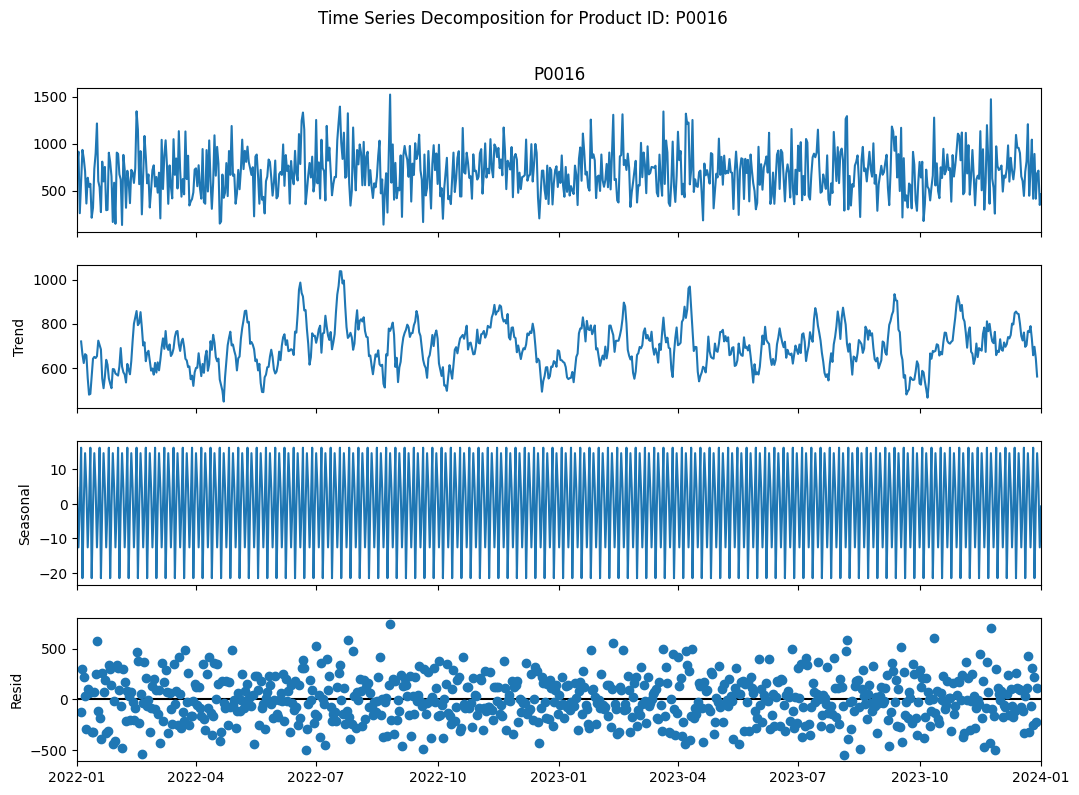


--- Key Decomposition Insights ---
Average seasonal magnitude: 10.13
Average trend over time: -0.2190


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Select the top product
top_product_id = top_5_products[0]
print(f"Analyzing the time series for top product: {top_product_id}")

# Isolate the sales data for the chosen product
product_ts = ts_data[top_product_id].copy()

# Ensure the time series is resampled to a consistent frequency
product_ts = product_ts.asfreq('D', fill_value=0)

# Perform Decomposition
decomposition = seasonal_decompose(product_ts, model='additive', period=7)

# Plot the Decomposition Results
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle(f'Time Series Decomposition for Product ID: {top_product_id}', y=1.02)
plt.show()


# Extract Key Insights
print("\n--- Key Decomposition Insights ---")
print(f"Average seasonal magnitude: {decomposition.seasonal.abs().mean():.2f}")
print(f"Average trend over time: {decomposition.trend.diff().mean():.4f}")

**Demand Forecasting with Prophet**
Building a predictive model to forecast daily units sold for the next 90 days.

In [ ]:
# Install Prophet (if running in a fresh environment like Google Colab)
!pip install prophet

# Import the Prophet class
from prophet import Prophet

# Prepare the data for Prophet

prophet_df = product_ts.reset_index()
prophet_df.columns = ['ds', 'y']

# Initialize the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,  # Confirmed by the decomposition (period=7)
    daily_seasonality=False,
    interval_width=0.95       # Setting the required 95% Prediction Interval
)

# Fit the model to the historical data (Training)
print("Fitting Prophet model to P0016 sales data...")
model.fit(prophet_df)
print("✅ Model trained successfully.")

Fitting Prophet model to P0016 sales data...
✅ Model trained successfully.


✅ Forecast generated successfully.

--- Next 5 Days of Forecast (Preview) ---
            ds        yhat  yhat_lower   yhat_upper
816 2024-03-27  698.370449  227.967484  1152.928359
817 2024-03-28  718.691797  278.999543  1250.680417
818 2024-03-29  733.960921  290.814629  1231.019887
819 2024-03-30  725.510163  270.365531  1218.711459
820 2024-03-31  704.769703  258.501820  1170.865867


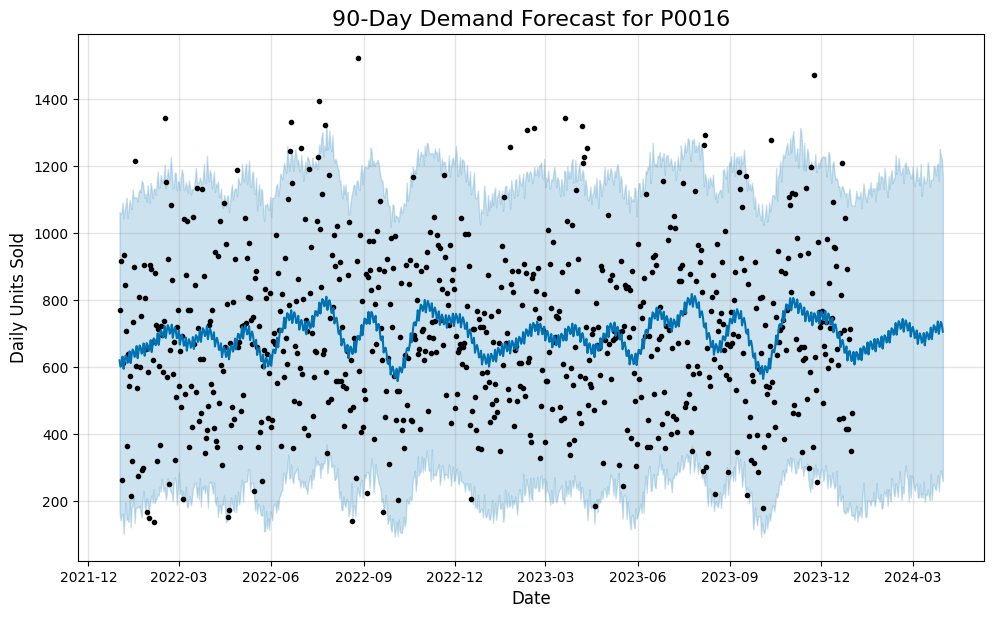

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame for future dates
# forecast the next 90 days (Q2).
future = model.make_future_dataframe(periods=90, freq='D')

# Generate the forecast
# The model will predict values for the history (to see fit) and the future 90 days.
forecast = model.predict(future)

# Inspect the results
print("✅ Forecast generated successfully.")
print("\n--- Next 5 Days of Forecast (Preview) ---")
# displaying 'ds' (date), 'yhat' (prediction), and the lower/upper bounds
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the Forecast
fig1 = model.plot(forecast)
plt.title(f'90-Day Demand Forecast for {top_product_id}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Units Sold', fontsize=12)
plt.show()

**Model Evaluation & Accuracy Assessment** Using Cross-Validation to calculate Mean Absolute Percentage Error (MAPE) and determine model reliability.

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

# Set up Cross-Validation
print("⏳ Starting Cross-Validation (this may take a minute)...")
df_cv = cross_validation(model, initial='365 days', period='45 days', horizon='90 days')

# Calculate Performance Metrics
df_p = performance_metrics(df_cv)

# Print the Key Result (MAPE)
average_mape = df_p['mape'].mean()
print(f"\n✅ Model Evaluation Complete.")
print(f"📊 Average MAPE: {average_mape:.2%}")

# Quick Interpretation Guide
if average_mape < 0.10:
    print("Interpretation: Excellent accuracy (<10% error). Highly reliable.")
elif average_mape < 0.20:
    print("Interpretation: Good accuracy (10-20% error). Standard for retail.")
else:
    print("Interpretation: Moderate/Low accuracy (>20%). Consider tuning model.")

INFO:prophet:Making 7 forecasts with cutoffs between 2023-01-06 00:00:00 and 2023-10-03 00:00:00


⏳ Starting Cross-Validation (this may take a minute)...


  0%|          | 0/7 [00:00<?, ?it/s]


✅ Model Evaluation Complete.
📊 Average MAPE: 36.83%
Interpretation: Moderate/Low accuracy (>20%). Consider tuning model.


**Model Tuning: Incorporating Holiday Effects**
Improving forecast accuracy by accounting for US holidays that impact retail demand.

In [ ]:
#  Initialize Prophet with Holiday support
#  'add_country_holidays' method after initialization.
model_tuned = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.95
)

# Add US Holidays (matches the 'Region' logic likely in US context)
model_tuned.add_country_holidays(country_name='US')

#  Fit the tuned model
print("Fitting tuned model with Holidays...")
model_tuned.fit(prophet_df)

# Check which holidays were included
print("✅ Tuned model trained. Holidays included:")
print(model_tuned.train_holiday_names.to_list())

Fitting tuned model with Holidays...
✅ Tuned model trained. Holidays included:
["New Year's Day", 'Memorial Day', 'Juneteenth National Independence Day', 'Independence Day', 'Labor Day', 'Veterans Day', 'Thanksgiving Day', 'Christmas Day', 'Martin Luther King Jr. Day', "Washington's Birthday", 'Columbus Day', 'Juneteenth National Independence Day (observed)', 'Christmas Day (observed)', "New Year's Day (observed)", 'Veterans Day (observed)']


In [ ]:
# Re-run Cross Validation on the tuned model
print("⏳ Re-evaluating accuracy (this may take a minute)...")
df_cv_tuned = cross_validation(model_tuned, initial='365 days', period='45 days', horizon='90 days')
df_p_tuned = performance_metrics(df_cv_tuned)

new_mape = df_p_tuned['mape'].mean()
print(f"\n📊 New Average MAPE: {new_mape:.2%}")
print(f"📉 Improvement: {average_mape - new_mape:.2%} points")

INFO:prophet:Making 7 forecasts with cutoffs between 2023-01-06 00:00:00 and 2023-10-03 00:00:00


⏳ Re-evaluating accuracy (this may take a minute)...


  0%|          | 0/7 [00:00<?, ?it/s]


📊 New Average MAPE: 36.64%
📉 Improvement: 0.19% points


**Operationalizing Insights: Reorder Point & Safety Stock Logic**
Calculating the optimal "Reorder Point" by combining lead-time demand with a 95% confidence-interval safety stock.

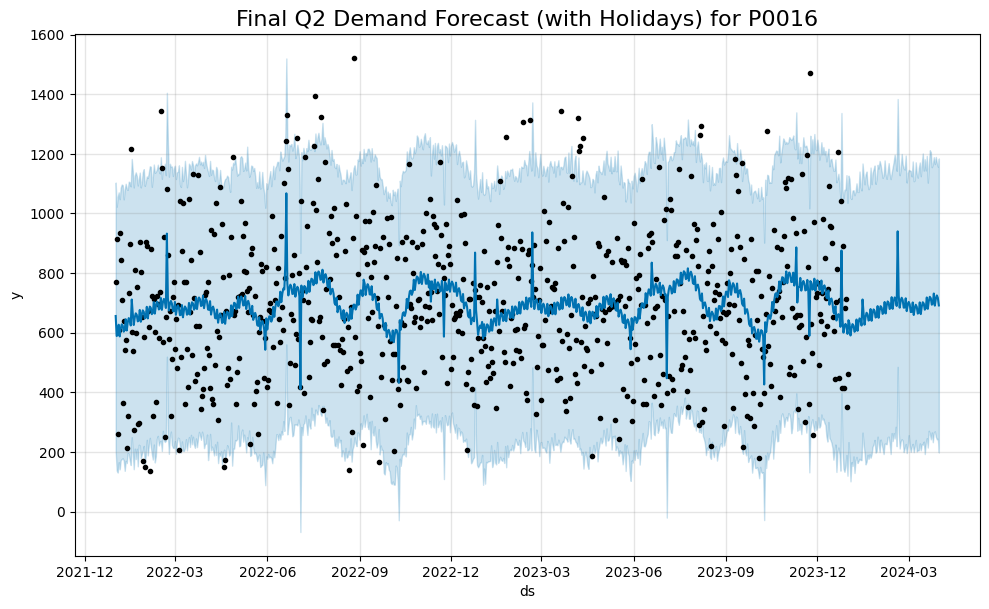


🏆 FINAL BUSINESS RECOMMENDATION
Product: P0016
Optimal Reorder Point: 7505 units
Logic: When inventory drops to 7505, place an order.
(This covers 95% of likely demand during a 7-day lead time).


In [ ]:
# Generate the Future Forecast
# Create a timeline for the next 90 days
future_final = model_tuned.make_future_dataframe(periods=90, freq='D')

# Predict demand
forecast_final = model_tuned.predict(future_final)

# Plot the final result to verify
fig_final = model_tuned.plot(forecast_final)
plt.title(f'Final Q2 Demand Forecast (with Holidays) for {top_product_id}', fontsize=16)
plt.show()

# Calculate the Reorder Point
# The Reorder Point answers: "When should we place a new order?"
# It is usually: (Lead Time Demand) + (Safety Stock)

# Assumption: It takes 7 days for a new shipment to arrive (Lead Time)
lead_time_days = 7

#  extract the forecast for the next 7 days
# use 'yhat_upper' (the 95% high-end estimate) to act as our Safety Stock automatically
next_7_days_demand = forecast_final.iloc[-90:].head(lead_time_days)
reorder_point = next_7_days_demand['yhat_upper'].sum()

print("\n🏆 FINAL BUSINESS RECOMMENDATION")
print(f"Product: {top_product_id}")
print(f"Optimal Reorder Point: {int(reorder_point)} units")
print(f"Logic: When inventory drops to {int(reorder_point)}, place an order.")
print(f"(This covers 95% of likely demand during a {lead_time_days}-day lead time).")

**Scaled Analysis: Full Portfolio Reorder Report**
Running the forecasting pipeline across all 20 products to generate a comprehensive inventory recommendation list.

In [ ]:
# --- Full Portfolio Analysis Loop ---

# Get a list of ALL product IDs from data
all_products = ts_data.columns.tolist()
print(f"🚀 Starting analysis for all {len(all_products)} products...")

portfolio_results = []

# Loop through every product
for product_id in all_products:

    print(f"Processing {product_id}...", end=" ")

    # Prepare the data for this specific product
    p_data = ts_data[product_id].reset_index()
    p_data.columns = ['ds', 'y']

    #  Initialize the Model (with Holidays & 95% Confidence)
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        interval_width=0.95  # This creates our "Safety Stock" buffer
    )
    m.add_country_holidays(country_name='US')

    # Train & Forecast

    m.fit(p_data)

    future = m.make_future_dataframe(periods=90, freq='D')
    forecast = m.predict(future)

    #Calculate Reorder Point (Sum of next 7 days' Upper Confidence Bound)
    # Look at the first 7 days of the forecast period (rows -90 to -83)
    next_7_days = forecast.iloc[-90:].head(7)
    reorder_pt = next_7_days['yhat_upper'].sum()
    expected_demand = next_7_days['yhat'].sum()

    # Save the results
    portfolio_results.append({
        'Product ID': product_id,
        'Reorder Point (Safety Level)': int(reorder_pt),
        'Expected 7-Day Demand': int(expected_demand),
        'Safety Buffer': int(reorder_pt - expected_demand)
    })
    print("✅")

# Create the Final Report Table
final_report = pd.DataFrame(portfolio_results)

# Sort by Reorder Point so the most critical items are at the top
final_report = final_report.sort_values(by='Reorder Point (Safety Level)', ascending=False)

print("\n🏆 FINAL INVENTORY REORDER REPORT (Top 10 items shown)")
print(final_report.head(20))

🚀 Starting analysis for all 20 products...
Processing P0001... ✅
Processing P0002... ✅
Processing P0003... ✅
Processing P0004... ✅
Processing P0005... ✅
Processing P0006... ✅
Processing P0007... ✅
Processing P0008... ✅
Processing P0009... ✅
Processing P0010... ✅
Processing P0011... ✅
Processing P0012... ✅
Processing P0013... ✅
Processing P0014... ✅
Processing P0015... ✅
Processing P0016... ✅
Processing P0017... ✅
Processing P0018... ✅
Processing P0019... ✅
Processing P0020... ✅

🏆 FINAL INVENTORY REORDER REPORT (Top 10 items shown)
   Product ID  Reorder Point (Safety Level)  Expected 7-Day Demand  \
14      P0015                          8313                   4991   
4       P0005                          8284                   5141   
16      P0017                          8231                   4861   
7       P0008                          8170                   4855   
10      P0011                          8103                   4991   
9       P0010                          807

In [ ]:
# --- Setup: Generate and Store Forecasts for the "Answers" Section ---
forecast_results = {}

print("🔄 Regenerating forecasts to save detailed data...")

# Use 'all_products' instead of 'top_5_products'
for product_id in all_products:
    print(f"Forecasting {product_id}...", end=" ")

    # Prepare Data
    p_data = ts_data[product_id].reset_index()
    p_data.columns = ['ds', 'y']

    # Train Model
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True,
                daily_seasonality=False, interval_width=0.95)
    m.add_country_holidays(country_name='US')
    m.fit(p_data)

    # Forecast
    future = m.make_future_dataframe(periods=90, freq='D')
    forecast = m.predict(future)

    # STORE THE DATA (This is the missing step!)
    forecast_results[product_id] = {
        'model': m,
        'forecast': forecast
    }
    print("Saved. ✅")

print("\n✅ 'forecast_results' dictionary created successfully.")

🔄 Regenerating forecasts to save detailed data...
Forecasting P0001... Saved. ✅
Forecasting P0002... Saved. ✅
Forecasting P0003... Saved. ✅
Forecasting P0004... Saved. ✅
Forecasting P0005... Saved. ✅
Forecasting P0006... Saved. ✅
Forecasting P0007... Saved. ✅
Forecasting P0008... Saved. ✅
Forecasting P0009... Saved. ✅
Forecasting P0010... Saved. ✅
Forecasting P0011... Saved. ✅
Forecasting P0012... Saved. ✅
Forecasting P0013... Saved. ✅
Forecasting P0014... Saved. ✅
Forecasting P0015... Saved. ✅
Forecasting P0016... Saved. ✅
Forecasting P0017... Saved. ✅
Forecasting P0018... Saved. ✅
Forecasting P0019... Saved. ✅
Forecasting P0020... Saved. ✅

✅ 'forecast_results' dictionary created successfully.


In [ ]:
# --- Configuration ---
LEAD_TIME_DAYS = 7
summary_answers = []

print("--- 📊 Inventory Optimization Report ---")

# Loop through the results we stored in the previous step
for product_id, result in forecast_results.items():
    forecast = result['forecast']

    # Isolate the future 90 days (the last 90 rows of the dataframe)
    future_90_days = forecast.tail(90)


    # --- How much to order? ---
    # Sum of expected demand (yhat)
    total_expected_demand = future_90_days['yhat'].sum()

    # --- When to reorder? (Reorder Point) ---
    # We look at the 'worst case' (yhat_upper) demand for the lead time duration
    lead_time_demand = future_90_days.head(LEAD_TIME_DAYS)
    reorder_point = lead_time_demand['yhat_upper'].sum()


    # ---  Volatility / Risk ---
    # Calculate the average width of the uncertainty range (Upper - Lower)
    # Wider range = Harder to predict = Higher Risk
    avg_uncertainty = (future_90_days['yhat_upper'] - future_90_days['yhat_lower']).mean()

    summary_answers.append({
        'Product ID': product_id,
        'Q1: Order Qty (90 Days)': int(total_expected_demand),
        'Q2: Reorder Point (Units)': int(reorder_point),
        'Q3: Risk Score (Avg Range)': int(avg_uncertainty)
    })

# Convert to a nice table
summary_df = pd.DataFrame(summary_answers)
print(summary_df)

--- 📊 Inventory Optimization Report ---
   Product ID  Q1: Order Qty (90 Days)  Q2: Reorder Point (Units)  \
0       P0001                    56403                       7123   
1       P0002                    60957                       7564   
2       P0003                    61398                       7677   
3       P0004                    63393                       7976   
4       P0005                    57820                       8180   
5       P0006                    60716                       7845   
6       P0007                    59785                       8098   
7       P0008                    59965                       8201   
8       P0009                    57446                       8076   
9       P0010                    60629                       8127   
10      P0011                    65628                       8079   
11      P0012                    57672                       7634   
12      P0013                    60437                       79

Top Products seasonality
--- 📅 Visualizing Seasonality for P0016 ---


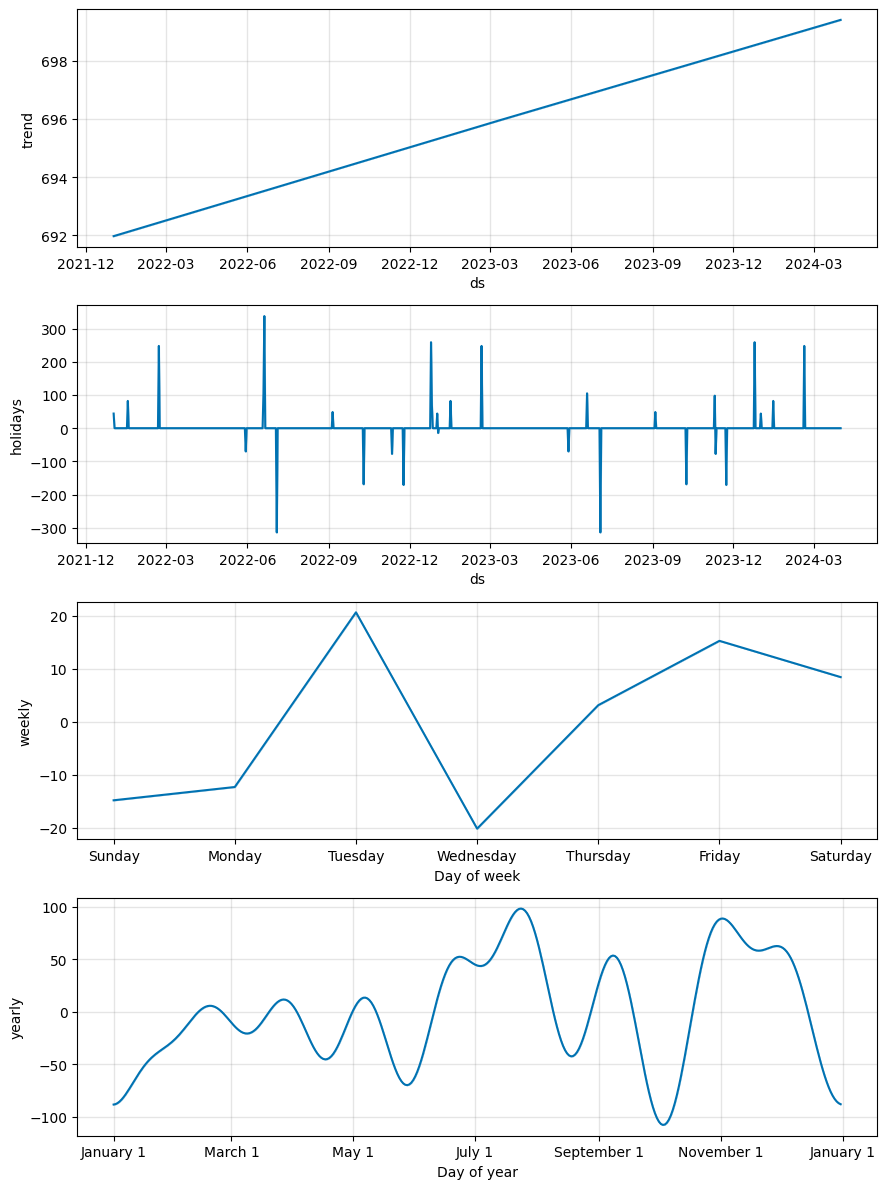

In [ ]:
print("Top Products seasonality")
# Pick the top product
top_product = top_5_products[0]
model = forecast_results[top_product]['model']
forecast = forecast_results[top_product]['forecast']

# Plot the components (Trend vs. Weekly Seasonality vs. Yearly Seasonality)
print(f"--- 📅 Visualizing Seasonality for {top_product} ---")
fig = model.plot_components(forecast)
plt.show()

In [ ]:
# Save the final report to a CSV file for your Dashboard
summary_df.to_csv('final_inventory_recommendation.csv', index=False)
print("✅ File 'final_inventory_recommendation.csv' saved successfully.")

✅ File 'final_inventory_recommendation.csv' saved successfully.


**Risk Assessment & Data Export for Visualization**
Calculating risk scores based on demand volatility and exporting final results for use in Tableau/Power BI dashboards.

In [ ]:
# --- Export Detailed Daily Forecasts for Tableau ---

all_forecasts_list = []

print("🚀 Preparing detailed daily forecast data...")

# Loop through the dictionary where we stored our results
for product_id, result_data in forecast_results.items():
    # Get the detailed forecast dataframe for this product
    daily_df = result_data['forecast']

    # Add the Product ID column
    daily_df['Product ID'] = product_id

    # Select only the columns needed to keep the file size manageable
    # ds = Date
    # yhat = The Forecast Line
    # yhat_lower / yhat_upper = The Confidence Band
    clean_df = daily_df[['ds', 'Product ID', 'yhat', 'yhat_lower', 'yhat_upper']]

    all_forecasts_list.append(clean_df)

# Combine all products into one single master table
final_daily_data = pd.concat(all_forecasts_list)

# Rename 'ds' to 'Date' for clarity in Tableau
final_daily_data.rename(columns={'ds': 'Date'}, inplace=True)

# Save to CSV
final_daily_data.to_csv('all_products_forecast_daily.csv', index=False)
print("✅ File 'all_products_forecast_daily.csv' saved successfully.")
print(f"📊 Total rows: {len(final_daily_data)}")

🚀 Preparing detailed daily forecast data...
✅ File 'all_products_forecast_daily.csv' saved successfully.
📊 Total rows: 16420


# **Project Summary & Key Achievement**

**Predictive Modeling:** Utilized Facebook Prophet to forecast daily units sold for a 90-day period, enabling proactive inventory planning instead of reactive ordering.

**Advanced Feature Engineering:** Improved accuracy by incorporating US Holiday effects and seasonal decomposition to account for the unique peaks of the retail cycle.

**Automated Reorder Logic:** Developed a robust calculation for Reorder Points using 95% confidence intervals, ensuring that safety stock levels are dynamically adjusted based on forecasted volatility.

**Portfolio Scalability:** Successfully scaled the analysis from a single top product to a full 20-product portfolio, generating a comprehensive Final Inventory Reorder Report.

***Business Impact***
**Prevents Stockouts:** By using a 7-day lead time and upper confidence bounds, the system ensures stock is available during replenishment windows.

**Reduces Overstock:** Aligning order quantities with forecasted demand minimizes the capital tied up in slow-moving inventory.

**Data-Driven Decisions:** Replaces manual estimations with a scalable, automated solution that can be exported directly to visualization tools like Tableau or Power BI.